In [7]:
import matplotlib.pyplot as plt
import pandas as pd 
from statsmodels.tsa.seasonal import seasonal_decompose
import os
dirname = os.getcwd()
plt.style.use('dark_background')


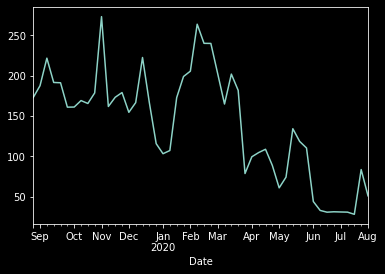

In [8]:
# My Personal Power Usage
filename = os.path.join(dirname, 'data.csv')

data = pd.read_csv(open(filename,'rb+'),index_col="Date")['Quantity']
data.index = pd.to_datetime(data.index, format='%m/%d/%Y')

#data = data.resample('W').sum()
data.resample('W').sum().plot()
data = data.to_frame()

In [9]:
print(data.describe())
print('Variance: ',data.var())

Quantity
count  347.000000
mean    20.269228
std     10.790766
min      3.000000
25%     11.292500
50%     21.142000
75%     28.133000
max     52.520000
Variance:  Quantity    116.440631
dtype: float64


<AxesSubplot:title={'center':'Daily Usage 7 Day Moving Average'}, xlabel='Date'>

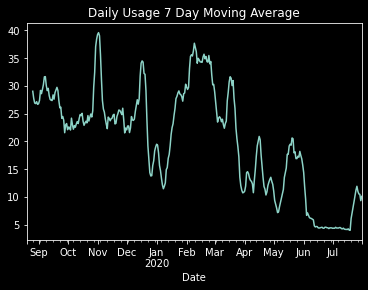

In [10]:
#Use a Moving Avg for daily data:
data['MA'] = data.rolling(window=7).mean()
plt.title("Daily Usage 7 Day Moving Average")
data['MA'].plot()

In [11]:
print(data['MA'].describe())
print('Variance: ',data['MA'].var())

count    341.000000
mean      20.272979
std        9.519841
min        4.001143
25%       12.176000
50%       22.584000
75%       27.395000
max       39.575571
Name: MA, dtype: float64
Variance:  90.62737536134185


<AxesSubplot:title={'center':'Weekly Seasonality'}, xlabel='Date'>

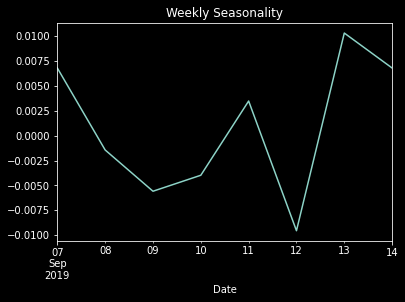

In [12]:
#Weekly Seasonality
data = data['MA'].dropna()
plt.title("Weekly Seasonality")
result = seasonal_decompose(data, model='additive',period=7)
result.seasonal['9/7/19':'9/14/19'].plot()


<AxesSubplot:title={'center':'Seasonality'}, xlabel='Date'>

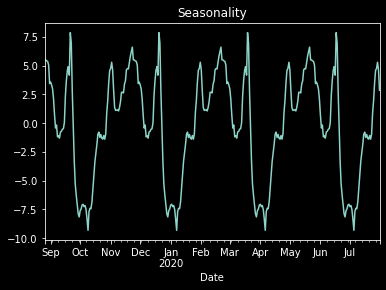

In [13]:
#Seasonality (90 Day)
plt.title("Seasonality")
result = seasonal_decompose(data, model='additive',period=(90))
result.seasonal.plot()
#Note higher power costs (avg) durring winter (as expected)

<AxesSubplot:xlabel='Date'>

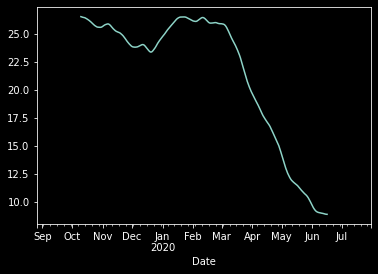

In [14]:
# The trend is not stationary, due to moving back home durring COVID
result.trend.plot()

<AxesSubplot:title={'center':'Weekly AEP demand'}, xlabel='Datetime'>

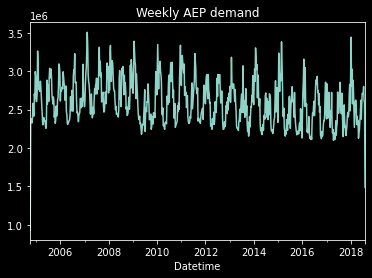

In [21]:
#Larger dataset for better analysis
plt.title("Weekly AEP demand")
data = pd.read_csv(open('AEP_hourly.csv','r'),index_col="Datetime")['AEP_MW']
data.index = pd.to_datetime(data.index, format='%Y-%m-%d %H:%M:%S')

data = data.resample('W').sum()
data.plot()


In [22]:
# Mean/Variance for the raw data
# Results in a high variance
mean = data.mean()
var = data.var()
print("Mean was  ", mean)
print("Variance was  " ,  var)

Mean was   2599823.6887966804
Variance was   83127453734.27837


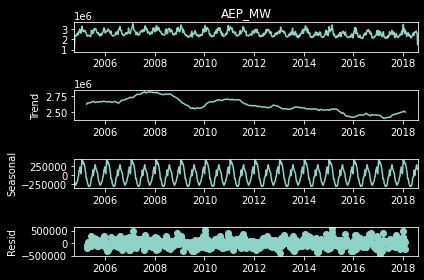

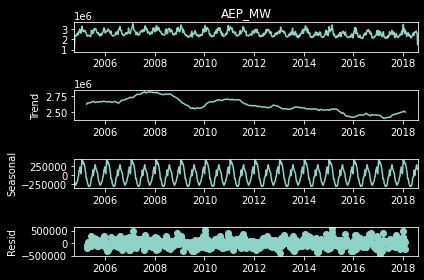

In [23]:
result = seasonal_decompose(data, model='additive',period=52)
result.plot()

<AxesSubplot:title={'center':'AEP Seasonality'}, xlabel='Datetime'>

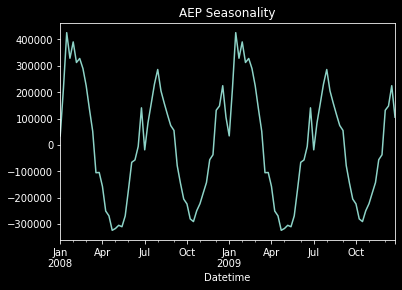

In [24]:
plt.title("AEP Seasonality")
result.seasonal['2008':'2009'].plot()

<AxesSubplot:title={'center':'AEP Trend'}, xlabel='Datetime'>

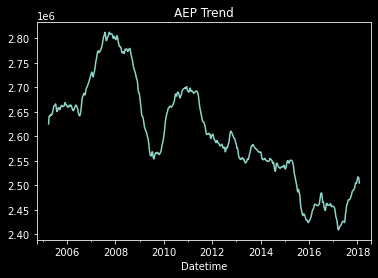

In [25]:
plt.title("AEP Trend")
result.trend.plot()

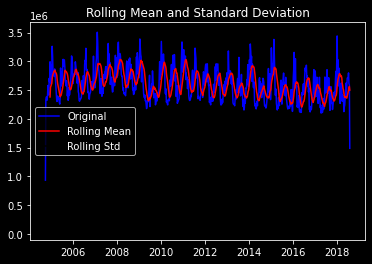

Results of dickey fuller test
Test Statistics                 -3.211035
p-value                          0.019355
No. of lags used                20.000000
Number of observations used    702.000000
critical value (1%)             -3.439700
critical value (5%)             -2.865666
critical value (10%)            -2.568967
dtype: float64


In [33]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(data)

<AxesSubplot:xlabel='Datetime'>

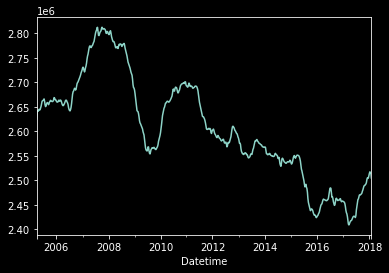

In [47]:
data = result.trend.dropna()
data.plot()

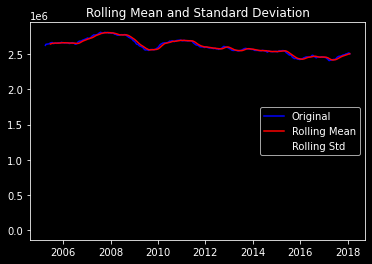

Results of dickey fuller test
Test Statistics                 -1.369901
p-value                          0.596618
No. of lags used                20.000000
Number of observations used    650.000000
critical value (1%)             -3.440450
critical value (5%)             -2.865997
critical value (10%)            -2.569143
dtype: float64


In [49]:
test_stationarity(data)

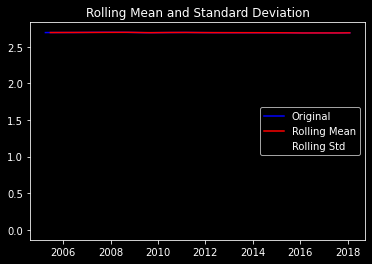

Results of dickey fuller test
Test Statistics                 -1.318389
p-value                          0.620718
No. of lags used                20.000000
Number of observations used    650.000000
critical value (1%)             -3.440450
critical value (5%)             -2.865997
critical value (10%)            -2.569143
dtype: float64


In [53]:
df_log = np.log(data)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
data = df_log.dropna()
test_stationarity(data)


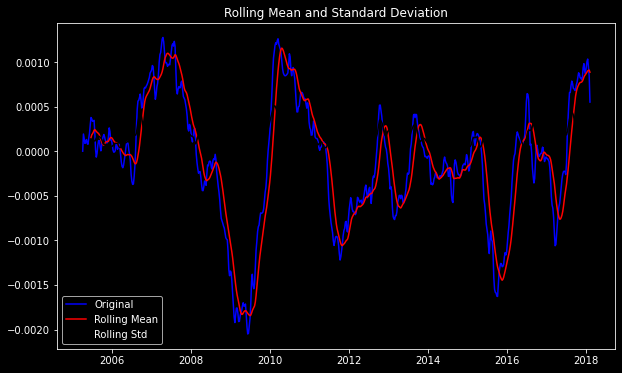

Results of dickey fuller test
Test Statistics                 -3.944602
p-value                          0.001730
No. of lags used                20.000000
Number of observations used    650.000000
critical value (1%)             -3.440450
critical value (5%)             -2.865997
critical value (10%)            -2.569143
dtype: float64


In [54]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()
logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

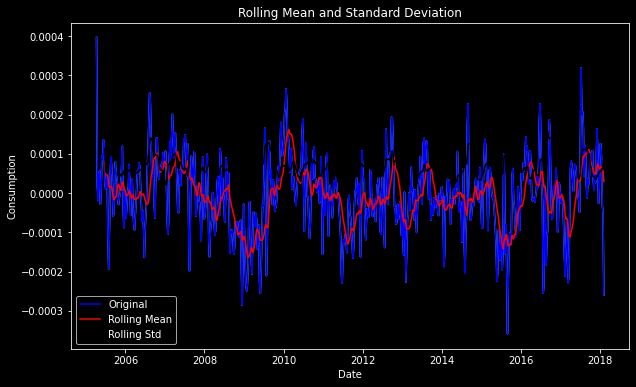

Results of dickey fuller test
Test Statistics                 -4.073145
p-value                          0.001072
No. of lags used                19.000000
Number of observations used    650.000000
critical value (1%)             -3.440450
critical value (5%)             -2.865997
critical value (10%)            -2.569143
dtype: float64


In [55]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)
#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

In [56]:
data = df_log_diff.dropna()

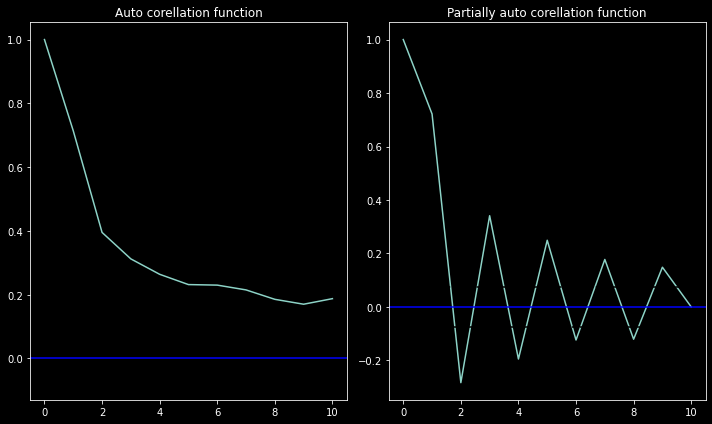

In [58]:
from statsmodels.tsa.stattools import acf,pacf
import numpy as np
# we use d value here(data_log_shift)
acf = acf(data, nlags=10)
pacf= pacf(data, nlags=10,method='ols')
#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()
#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

Text(0.5, 1.0, 'sum of squares of residuals')

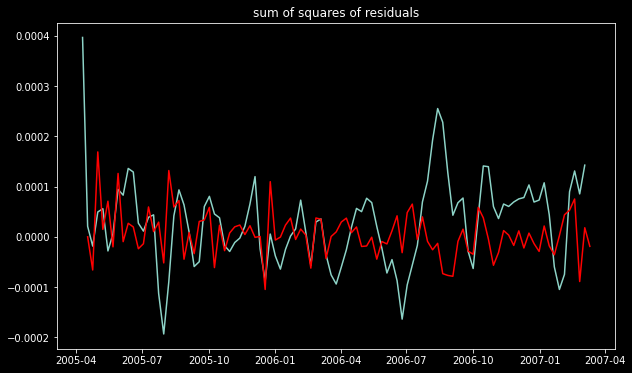

In [67]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(data, order=(2,1,2))
result_AR = model.fit(disp = 0)
plt.plot(data[:100])
plt.plot(result_AR.fittedvalues[:100], color='red')
plt.title("sum of squares of residuals")

In [70]:
result_AR.plot_predict(1,500)
x=result_AR.forecast(steps=200)
plot(x)
plt.show

NameError: name 'plot' is not defined